# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link:https://colab.research.google.com/drive/1rJV4HyldaHmy0eKPbPfzq4HD880gZccc?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


class TextGenerator(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(TextGenerator, self).__init__()
        # Identity matrix for generating 1-hot vectors
        self.ident = torch.eye(vocab_size)
        # Recurrent neural network
        self.rnn = nn.GRU(vocab_size, hidden_size, batch_first=True)
        # A FC layer outputting a distribution over the next token
        self.decoder = nn.Linear(hidden_size, vocab_size)

    def forward(self, inp, hidden=None):
        # Generate 1-hot vectors of input
        inp = self.ident[inp]
        # Get the next output and hidden state
        output, hidden = self.rnn(inp, hidden)
        # Predict distribution over next tokens
        output = self.decoder(output)
        return output, hidden

def train(model, data, batch_size=1, num_epochs=1, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    data_iter = torchtext.legacy.data.BucketIterator(data,
                                                    batch_size=batch_size,
                                                    sort_key=lambda x: len(x.text),
                                                    sort_within_batch=True)

    for _ in range(num_epochs):
        avg_loss = 0
        for (tweet, lengths), label in data_iter:
            target = tweet[:, 1:]
            inp = tweet[:, :-1]
            optimizer.zero_grad()
            output, _ = model(inp)
            loss = criterion(output.reshape(-1, vocab_size), target.reshape(-1))
            loss.backward()
            optimizer.step()

def sample(sample, max_len=100, temperature=0.8):
    generated_sequence = ''
    inp = torch.Tensor([vocab_stoi['<BOS>']]).long()
    hidden = None
    for p in range(max_len):
        output, hidden = model(inp.unsqueeze(0), hidden)
        # Sample from the model as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted character to string and use as next input
        predicted_char = vocab_itos[top_i]
        if predicted_char == '<EOS>':
            break
        generated_sequence += predicted_char
        inp = torch.Tensor([top_i]).long()
    return generated_sequence

## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:01<00:00, 101927478.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

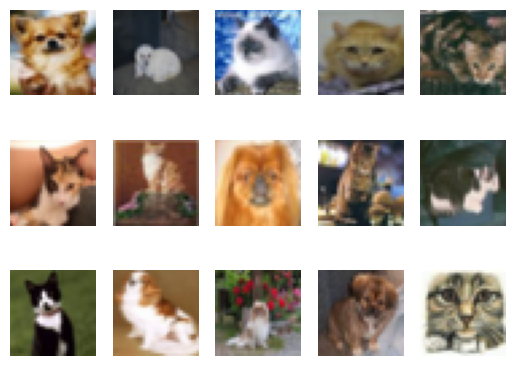

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
print(train_loader.__len__())
print(val_loader.__len__())
print(test_loader.__len__())


8000
2000
2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
# Since we are training our model with multiple hyperparametres we need the
# validation data to help us decide which model has the optimal hyperparametres
# We cannot use the training data to judge the performance of our model as
# the model has already seen the training data and might have memorized it
# resulting in overfitting which would mean the model would have a 100 accuracy
# on the training data, but would not be generalized enough to fit data which
# it has never seen before

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
result = 0
for param in small_net.parameters():
    x = param.shape
    result += np.prod(np.array(x))

print("small net: " + str(result))
result = 0

for param in large_net.parameters():
    x = param.shape
    result += np.prod(np.array(x))

print("large net: " + str(result))

small net: 386
large net: 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [ ]:
print(" batch_size = 64 \n learning_rate = 0.01 \n num_epochs = 30")

 batch_size = 64 
 learning_rate = 0.01 
 num_epochs = 30


### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
# 5 files are saved to the disk after each opech containing the values of the model parameters
# there will also be a file saved after each epoch those files being:
# a file containing the training error
# a file containing the training loss
# a file containing the validation error
# a file containing the validation loss

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
small_net = SmallNet()
large_net = LargeNet()
train_net(small_net)
train_net(large_net)

The large network took around (176-162=14s) 14 seconds longer to train. This is because it contains more paramters than the small network as seen in part 2a. More parameters means the for each iteration the model has to calculate and update more gradients resulting in an increase in time.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

In [ ]:
model_path1 = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
model_path2 = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)

print("Small\n")
plot_training_curve(model_path1)

print("\n\nLarge\n")
plot_training_curve(model_path2)

Small



FileNotFoundError: ignored

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

The training curve is constantly decreasing for both large and small network.


The large network seems to be overfitting as validation loss starts to increase at around 10 epochs while the training error/loss is still decreasing.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Streaming output truncated to the last 5000 lines.
tensor([0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 1., 1., 0.])
tensor([0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
        1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 1., 0., 0., 1., 0.])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
  

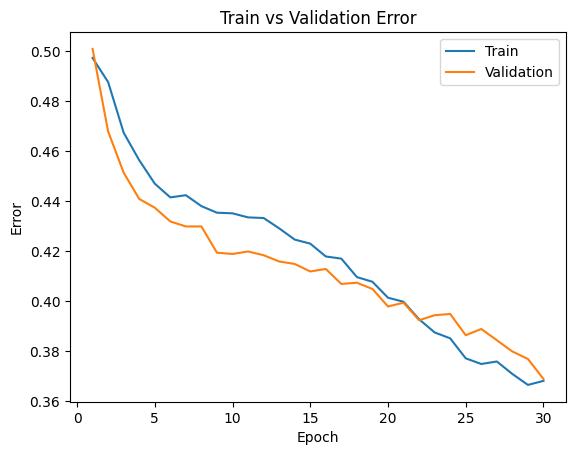

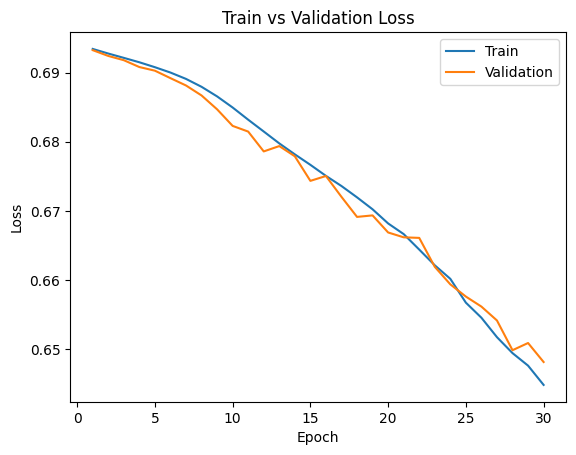

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30)

model_path2 = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path2)

It took about the same tome to train the network with lr=0.001.
Lowering the learning rate decreases how fast the model changed, as we can see now the curves for the training and validation error/loss follow each other much more closly. Also the y-axis starts at a higher value than before indicating the model doesnt expireince as much change as before, this helps solve the issue of overfitting

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)

model_path2 = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path2)

It took about the same time to train the network with lr=0.1. Increasing the learning rate also increased how dratstically the network shifts as seen by the graph, where there are large shifts in the network error/loss between epochs. Also the problem of overfitting has become more apparant as the validation and test data deviate from each other much earlier at around 5 epochs



### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)

model_path2 = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path2)

It took about 15 seconds less to train the network with batch_size=512, this is probably becausethe network now considers much more data at the same time by taking the average, this means it has to less calculations of gradients to update the weights increasing the processing time. Increasing the batch size also causes the model to underfit as seen in the graph where the training and error/loss curves are still decreasing with the number of epochs. This is most likely due to the reasoning for the lowred time as the model is now considering less data points overall resulting in a less fitted model

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)

model_path2 = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path2)

The training time for the model increased by about 90 seconds for the model with batch_size=16. This is most likely because the model looks at data in smaller batches meaning the number of batches being computed increases over the entire data set, these extra computations result in increased computation time. Furthermore, the model seems to overfitting to the data now as the validtion error/loss starts increasing around 10 epochs while the training error/loss continues to decrease. Again, this is most likely due to the extra calculations from the lowered batch size causing the model to have an increased amount of data points causing it to memorize instead of understand

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

network = large_net

batch_size = 320

learning_rate = 0.005

Since our original network was overfitting to the data I have chosen the parameters which cause the network to underfit. This means decreasing the learning rate and increasing the batch size.

Looking at the network type I chose the large network as that is the network we tested hyperparameters for in part 3

Looking at the batch size we can see that increasing the batch size caused the model to perform better, but a batch size of 512 was too large and caused the model to underfit. Thus I increased the batch size to 320.

Looking at the learning rate a lower value caused the model to perform better,but a lr of 0.001 was too small and caused the network to underfit too much. Thus I decreased the lr to 0.005 in hopes it would strike the sweet spot between over and under fitting.


### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net, 320, 0.005, 30)

model_path2 = get_model_name("large", batch_size=320, learning_rate=0.005, epoch=29)
plot_training_curve(model_path2)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

network = large

batch_size = 320

learning rate = 0.003

number epochs = 90

Looking at the results of the last training the model is underfitting on the loss function and seems to be overfitting on the error function. To account for this I have decided to decrease the lr to 0.003 and increase the epoch number to 60. I'm hoping this will help overcome the differences between the error and loss functions by decreasing the error.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net, 320, 0.003, 90)

model_path2 = get_model_name("large", batch_size=320, learning_rate=0.003, epoch=89)
plot_training_curve(model_path2)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=320, learning_rate=0.003, epoch=89)
state = torch.load(model_path)
net.load_state_dict(state)

### Part (b) - 2pt

Justify your choice of model from part (a).

I chose the model I trained in part 3d as even though it diverges it still gets the lowest values for the validation data out of all the previos models I created meaning it is best suited for the test data

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=320)

criterion = nn.BCEWithLogitsLoss()


vals = evaluate(net, val_loader, criterion)

print("error: ", vals[0])
print("loss: ", vals[1])

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

test error: 0.339

validation error: 0.335

The test error is higher than the validation error as the model I chose is the one which performed best on the validation error. Thus even though the model was never actually trained on the validation error it was chosen due to its performence on it which makes it biased to do better on the validation data compared to the test data which it never saw.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

We only use the test data at the very end to simulate the accuracy of the model in the real world where we will not know what the test data is until the model sees it. We use the test data as little as possible to avoid introducing bias in our model. If we chose the model which performed best on the test data aswell we wouldn't have any real metric to test the accuracy of our model

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.name = "NN"
        self.layer1 = nn.Linear(3*32*32, 64)
        self.layer2 = nn.Linear(64, 1)
        # self.layer3 = nn.Linear(20, 10)
        # self.layer4 = nn.Linear(10, 10)
        # self.dropout = nn.Dropout(0.05)

    def forward(self, img):
        flattened = img.view(-1, 3*32*32)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = (F.relu(self.layer2(activation1))).squeeze(1)
        # activation3 = self.layer3(activation2)
        return activation2

model = NN()
train_net(model, 512, 0.001, 30)

In [ ]:
ANN_model_path = get_model_name("NN", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(ANN_model_path)

In [ ]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)

criterion = nn.BCEWithLogitsLoss()


vals = evaluate(model, val_loader, criterion)

print("error: ", vals[0])
print("loss: ", vals[1])

ANN Test Error: 0.3835

CNN Test Error: 0.339

After changing the hyperparameters of the ANN this is the lowest I was able to get it to. As we can see the CNN outperforms the ANN on the test error which is to be expected